# COMP90051 Project 2

In [1]:
# Do not edit. These are the only imports permitted.
%matplotlib inline
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod

## 1. Implement ε-Greedy and UCB

In [2]:
"""
todo
1. Exception处理
2. 英文翻译
"""
class MAB(ABC):
    """
    Abstract class that represents a multi-armed bandit (MAB)
    """
    
    @abstractmethod
    def play(self, tround, context):
        """
        Play a round
        
        Arguments
        =========
        tround : int
            positive integer identifying the round
        
        context : 1D float array, shape (self.ndims * self.narms), optional
            context given to the arms
        
        Returns
        =======
        arm : int
            the positive integer arm id for this round
        """
    
    @abstractmethod
    def update(self, arm, reward, context):
        """
        Updates the internal state of the MAB after a play
        
        Arguments
        =========
        arm : int
            a positive integer arm id in {1, ..., self.narms}
        
        reward : float
            reward received from arm
        
        context : 1D float array, shape (self.ndims * self.narms), optional
            context given to arms
        """

In [3]:
def index_max(input_list):
    """
    return the index of the max element in the list.
    NOTICE: Tie-breaking uniformly among value-maximising arms.
    arm 0 是第一个arm
    """
    m = max(input_list)
    if m == np.inf:
        index_list = [i for i, j in enumerate(input_list) if j==np.inf]
    else:
        # handle with float
        index_list = [i for i, j in enumerate(input_list) if (abs(j-m)<=0.000001)]
        
    if len(index_list) == 1:
        return index_list[0]
    else:
        return np.random.choice(index_list)

In [51]:
class EpsGreedy(MAB):
    """
    Epsilon-Greedy multi-armed bandit

    Arguments
    =========
    narms : int
        number of arms

    epsilon : float
        explore probability

    Q0 : float, optional
        initial value for the arms
    """
    
    def __init__(self, narms, epsilon, Q0=np.inf):
        self.narms=narms
        self.epsilon=epsilon
        # 记录每一个arm的pull的次数和得到的reward
        self.counts = [0 for col in range(self.narms)]
        self.avg_rewards = [Q0 for col in range(self.narms)]
        
    def play(self, tround, context=None):
        """
        Play a round
        play t-1轮的
        Arguments
        =========
        tround : int
            positive integer identifying the round
        context : 1D float array, shape (self.ndims * self.narms), optional
            context given to the arms
        
        Returns
        =======
        arm : int
            the positive integer arm id for this round
        """
        # exploit
        if np.random.random() > self.epsilon:
            # t-1轮中的average reward中最大的
            return index_max(self.avg_rewards)
        else:
        # explore
            return np.random.randint(self.narms)
        
    def update(self, arm, reward, context=None):
        """
        Updates the internal state of the MAB after a play
        更新t轮的
        Arguments
        =========
        arm : int
            a positive integer arm id in {1, ..., self.narms}
        
        reward : float
            reward received from arm
        
        context : 1D float array, shape (self.ndims * self.narms), optional
            context given to arms
        """
        self.counts[arm] = self.counts[arm] + 1
        n = self.counts[arm]
        old_avg_reward = self.avg_rewards[arm]
        new_avg_reward = (old_avg_reward * (n-1) + reward)/n
        self.avg_rewards[arm] = new_avg_reward

In [ ]:
# todo
# 它的下一个是顺序下来找的，还是所有里面的随机找。


In [82]:
class UCB(MAB):
    """
    Upper Confidence Bound (UCB) multi-armed bandit

    Arguments
    =========
    narms : int
        number of arms

    rho : float
        positive real explore-exploit parameter

    Q0 : float, optional
        initial value for the arms
    """
    
    def __init__(self, narms, rho, Q0=np.inf):
        self.narms = narms
        self.rho = rho
        # 记录每一个arm的次数和reward
        self.counts = [0 for col in range(self.narms)]
        self.avg_rewards = [Q0 for col in range(self.narms)]
        
    def play(self, tround, context=None):
        """
        Play a round
        t-1 round
        Arguments
        =========
        tround : int
            positive integer identifying the round
        context : 1D float array, shape (self.ndims * self.narms), optional
            context given to the arms
        
        Returns
        =======
        arm : int
            the positive integer arm id for this round
        """
        # tround is used for UCB
        q_values = [0.0 for arm in range(self.narms)]
        for arm in range(self.narms):
            # todo 这里其他人怎么处理
            if self.counts[arm] == 0:
                bonus = 0
            else:
                # 看下evaluation的tround是不是第t轮而不是t-1轮的结果
                bonus = np.sqrt((self.rho*np.log(tround))/self.counts[arm])
            # 是使得当前tround下达到最大的，和update不一样，update是选完arm后的action.
            q_values[arm] = self.avg_rewards[arm] + bonus
        return index_max(q_values)
        
        
    def update(self, arm, reward, context=None):
        """
        Updates the internal state of the MAB after a play
        需要update avg_rewards和self.counts
        Arguments
        =========
        arm : int
            a positive integer arm id in {1, ..., self.narms}
        
        reward : float
            reward received from arm
        
        context : 1D float array, shape (self.ndims * self.narms), optional
            context given to arms
        """
        self.counts[arm] = self.counts[arm] + 1
        n = self.counts[arm]
        old_avg_reward = self.avg_rewards[arm]
        new_avg_reward = (old_avg_reward * (n-1) + reward)/n
        self.avg_rewards[arm] = new_avg_reward

## 2. Off-Policy Evaluation

In [53]:
def offlineEvaluate(mab, arms, rewards, contexts, nrounds=None):
    """
    Offline evaluation of a multi-armed bandit
    
    Arguments
    =========
    mab : instance of MAB
    
    arms : 1D int array, shape (nevents,) 
        integer arm id for each event
    
    rewards : 1D float array, shape (nevents,)
        reward received for each event
    
    contexts : 2D float array, shape (nevents, mab.narms*nfeatures)
        contexts presented to the arms (stacked horizontally) 
        for each event.
        
    nrounds : int, optional
        number of matching events to evaluate `mab` on.
    
    Returns
    =======
    out : 1D float array
        rewards for the matching events
    """
    rewards_for_matched_round = []
    tround = 1
    length = len(rewards)
    for context_round in range(length):
        # tround是从0开始的
        # end  
        # pull/play 一次
        context = contexts[context_round]
        response_arm = int(arms[context_round]-1)
        response_reward = rewards[context_round]
        estimate_arm = int(mab.play(tround, context))
        if estimate_arm == response_arm:
            tround += 1
            rewards_for_matched_round.append(response_reward)
            # update
            mab.update(response_arm, response_reward, context)
            break
        if tround > nrounds:
            break
    return rewards_for_matched_round

In [7]:
# load the data
dataset = np.loadtxt('dataset.txt', dtype=int)
arms = dataset[:,0]
rewards = dataset[:,1]
contexts = dataset[:,2:102]

In [296]:
import pandas as pd
df = pd.DataFrame(dataset)
df.groupby(1).count()

,0,2,3,4,5,6,7,8,9,10,...,92,93,94,95,96,97,98,99,100,101
1,,,,,,,,,,,,,,,,,,,,,
0,8961,8961,8961,8961,8961,8961,8961,8961,8961,8961,...,8961,8961,8961,8961,8961,8961,8961,8961,8961,8961
1,1039,1039,1039,1039,1039,1039,1039,1039,1039,1039,...,1039,1039,1039,1039,1039,1039,1039,1039,1039,1039


In [224]:
mab = EpsGreedy(10, 0.05)
results_EpsGreedy = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('EpsGreedy average reward', np.mean(results_EpsGreedy))

inf
[]


ValueError: a must be non-empty

In [85]:
mab = UCB(10, 1.0)
results_UCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('UCB average reward', np.mean(results_UCB))

UCB average reward 0.15637319316688567


## 3. Contextual Bandits

In [70]:
class LinUCB(MAB):
    """
    Contextual multi-armed bandit (LinUCB)

    Arguments
    =========
    narms : int
        number of arms

    ndims : int
        number of dimensions for each arm's context

    alpha : float
        positive real explore-exploit parameter
    """
    
    def __init__(self, narms, ndims, alpha):
        self.narms = narms
        self.ndims = ndims
        self.alpha = alpha
        self.A_list = [np.identity(ndims) for col in range(self.narms)]
        self.b_list = [np.zeros((ndims, 1)) for col in range(self.narms)]

    def play(self, tround, context=None):
        """
        Play a round
        
        Arguments
        =========
        tround : int
            positive integer identifying the round
        context : 1D float array, shape (self.ndims * self.narms), optional
            context given to the arms
        
        Returns
        =======
        arm : int
            the positive integer arm id for this round
        """
        p_ta_list = [0.0 for col in range(self.narms)]
        for arm in range(self.narms):
#             print('start')
            context_arm = context[arm*10:(arm+1)*10]
#             print(context_arm.shape)
            # todo
            x_ta = np.array(context_arm).reshape(-1,1)
#             print(x_ta.shape)
            theta_a = np.dot(inv(self.A_list[arm]), self.b_list[arm])
#             print(theta_a)
            p_ta = np.dot(theta_a.T, x_ta) + self.alpha*np.sqrt(np.linalg.multi_dot([x_ta.T, inv(self.A_list[arm]), x_ta]))
            p_ta_list.append(p_ta[0][0])
        print(p_ta_list)
        return index_max(p_ta_list)
        
    def update(self, arm, reward, context=None):
        """
        Updates the internal state of the MAB after a play
        Arguments
        =========
        arm : int
            a positive integer arm id in {1, ..., self.narms}
        
        reward : float
            reward received from arm
        
        context : 1D float array, shape (self.ndims * self.narms), optional
            context given to arms
        """
        old_A_value = np.array((self.A_list[arm]))
        old_b_value = np.array((self.b_list[arm]))
        context_arm = context[arm*10:(arm+1)*10]
        x_tat = np.array(context_arm).reshape(-1,1)    
        self.A_list[arm] = old_A_value + np.dot(x_tat, x_tat.T)
        self.b_list[arm] = old_b_value + reward * x_tat
    

In [71]:
mab = LinUCB(10, 10, 1.0)
results_LinUCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('LinUCB average reward', np.mean(results_LinUCB))
# linUCB不是固定的么

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 45.332107826572546, 14.933184523068078, 33.645207682521445, 1.4142135623730951, 3.0, 4.0, 14.106735979665885, 6.164414002968976, 47.06378650300037, 34.85685011586675]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.138621999185304, 14.035668847618199, 23.388031127053, 29.017236257093817, 37.14835124201342, 7.280109889280518, 53.094255809833136, 27.459060435491963, 6.164414002968976, 11.661903789690601]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 12.24744871391589, 42.77849927241488, 4.58257569495584, 51.478150704935004, 7.874007874011811, 4.0, 53.376024580330075, 10.099504938362077, 25.67099530598687]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 84.39194274336857, 19.1049731745428, 1.0, 10.862780491200215, 18.303005217723125, 39.74921382870358, 7.280109889280518, 14.933184523068078, 4.0, 6.708203932499369]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 61.56297588648554, 0.0, 3.1622776601683795, 42.178193417

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 79.5361553005927, 31.0, 2.6457513110645907, 8.18535277187245, 16.34013463836819, 40.33608806019741, 5.0, 10.099504938362077, 3.1622776601683795, 15.165750888103101]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 87.66413177577246, 25.019992006393608, 1.7320508075688772, 11.61895003862225, 21.95449840010015, 30.93541659651604, 5.0990195135927845, 9.643650760992955, 1.4142135623730951, 7.54983443527075]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 54.53439281774392, 3.0, 7.0710678118654755, 40.26164427839479, 3.0, 6.082762530298219, 0.0, 45.967379738244816, 42.82522621072771, 11.090536506409418]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 71.0, 36.26292872893749, 2.23606797749979, 2.23606797749979, 3.605551275463989, 51.03920062069938, 31.352830813181765, 3.7416573867739413, 8.246211251235321, 17.349351572897472]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 54.24020648928247, 0.0, 10.392304845413264, 33.22649545167

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 55.5517776493246, 1.0, 8.54400374531753, 25.436194683953808, 5.0, 7.14142842854285, 2.0, 36.6333181680284, 52.744667976962376, 9.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 76.4591394144611, 23.021728866442675, 4.47213595499958, 11.180339887498949, 15.297058540778355, 45.12205669071391, 2.449489742783178, 12.609520212918492, 5.830951894845301, 4.69041575982343]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 74.89993324429602, 23.043437243605826, 2.449489742783178, 12.727922061357855, 14.142135623730951, 39.52214569073901, 12.165525060596439, 12.24744871391589, 3.7416573867739413, 9.433981132056603]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 58.0430874437258, 15.231546211727817, 6.708203932499369, 51.54609587543949, 5.0, 35.11409973215888, 13.076696830622021, 17.97220075561143, 15.066519173319364, 11.224972160321824]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 45.28796749689701, 2.0, 7.0, 39.382737335030434,

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 57.784080852774665, 16.522711641858304, 7.0, 56.72741841473134, 3.605551275463989, 40.311288741492746, 11.445523142259598, 19.313207915827967, 8.246211251235321, 16.278820596099706]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 78.26876771739798, 15.811388300841896, 2.23606797749979, 12.36931687685298, 20.54263858417414, 39.14077158156185, 3.605551275463989, 13.564659966250536, 2.449489742783178, 8.774964387392123]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 43.40506882842141, 17.204650534085253, 39.91240408695021, 0.0, 2.0, 0.0, 11.74734012447073, 5.830951894845301, 59.08468498688979, 30.983866769659336]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 39.61060464067672, 10.392304845413264, 45.18849411078001, 5.0990195135927845, 2.0, 2.0, 18.2208671582886, 2.449489742783178, 51.01960407529639, 31.52776554086889]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 49.53786430600334, 2.0, 9.055385138137417, 31.3049516849970

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.07135583350036, 12.409673645990857, 42.638011210655684, 5.0, 1.0, 4.0, 14.89966442575134, 7.3484692283495345, 60.07495318350236, 32.848135411313685]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 42.08325082500163, 99.18669265581951, 8.0, 5.916079783099616, 9.899494936611665, 20.396078054371138, 11.269427669584644, 19.77371993328519, 3.7416573867739413, 13.638181696985855]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 78.19207120929845, 23.08679276123039, 2.23606797749979, 12.206555615733702, 15.968719422671311, 46.314144707637645, 3.1622776601683795, 15.84297951775486, 2.449489742783178, 8.602325267042627]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 52.67826876426369, 2.23606797749979, 10.246950765959598, 42.391036788453285, 5.0, 8.306623862918075, 1.0, 46.72258554489466, 37.8021163428716, 10.44030650891055]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 49.59838707054898, 5.0, 8.0, 36.345563690772494, 5.0, 11.1

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 74.73285756613352, 25.179356624028344, 1.7320508075688772, 9.055385138137417, 19.493588689617926, 37.107950630558946, 5.0, 12.84523257866513, 3.605551275463989, 8.12403840463596]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.07135583350036, 14.035668847618199, 28.687976575562104, 35.0, 34.27827300200522, 8.774964387392123, 40.2119385257662, 20.12461179749811, 2.23606797749979, 15.033296378372908]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0624390837628, 17.029386365926403, 25.357444666211933, 45.0, 32.526911934581186, 7.3484692283495345, 53.23532661682466, 21.236760581595302, 8.06225774829855, 14.89966442575134]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 58.215118311311535, 1.4142135623730951, 8.06225774829855, 24.779023386727733, 6.0, 12.12435565298214, 1.4142135623730951, 47.80167361086848, 41.86884283091664, 14.177446878757825]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 44.74371464239419, 85.052924

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 49.8196748283246, 1.0, 7.0710678118654755, 44.05678154382138, 3.0, 9.486832980505138, 2.449489742783178, 50.57667446560717, 38.92300091205713, 17.029386365926403]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 54.22176684690383, 3.0, 12.0, 33.12099032335839, 5.0, 11.090536506409418, 2.0, 41.0731055558257, 43.197222132910355, 11.789826122551595]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 77.83957862167549, 26.076809620810597, 1.4142135623730951, 7.0710678118654755, 20.37154878746336, 47.45524207081869, 6.082762530298219, 9.899494936611665, 4.795831523312719, 7.0710678118654755]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 74.09453421137081, 25.099800796022265, 1.4142135623730951, 6.855654600401044, 23.021728866442675, 37.12142238654117, 2.449489742783178, 11.575836902790225, 3.3166247903554, 11.74734012447073]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.058772731852805, 13.0, 20.074859899884732, 45.0111097397

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 40.07492981902776, 14.0, 26.343879744638983, 46.010868281309364, 35.08560958569767, 7.874007874011811, 38.17066936798463, 25.019992006393608, 4.123105625617661, 15.811388300841896]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 49.8998997994986, 95.3205119583398, 13.379088160259652, 9.273618495495704, 6.0, 23.0, 4.898979485566356, 14.594519519326424, 1.7320508075688772, 10.488088481701515]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 84.38601779915912, 21.118712081942874, 4.242640687119285, 9.433981132056603, 16.55294535724685, 40.82891132518721, 2.6457513110645907, 13.45362404707371, 1.4142135623730951, 11.357816691600547]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.0, 6.48074069840786, 31.701734968294716, 7.3484692283495345, 46.09772228646444, 7.874007874011811, 2.0, 69.23871749245504, 9.486832980505138, 28.600699292150182]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.080540535840107, 17.146428199482248, 2

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 42.24926034855522, 17.86057109949175, 2.8284271247461903, 61.61168720299745, 5.830951894845301, 41.737273509418415, 7.3484692283495345, 22.64950330581225, 12.449899597988733, 19.026297590440446]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 78.64477096412705, 23.108440016582687, 0.0, 9.9498743710662, 22.38302928559939, 33.27160951922825, 4.123105625617661, 14.38749456993816, 2.23606797749979, 11.180339887498949]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 53.422841556772326, 0.0, 13.341664064126334, 38.18376618407357, 4.0, 7.3484692283495345, 0.0, 39.05124837953327, 46.151923036857305, 9.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.014282800023196, 20.0, 21.2602916254693, 36.124783736376884, 33.34666400106613, 5.385164807134504, 47.265209192385896, 28.160255680657446, 5.0, 12.727922061357855]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 44.395945760846224, 20.149441679609886, 5.0, 53.72150407425317, 4.1231

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.06225774829855, 8.12403840463596, 33.21144381083123, 7.0, 37.36308338453881, 13.92838827718412, 0.0, 56.142675390472796, 15.066519173319364, 32.71085446759225]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 60.88513775955508, 0.0, 12.083045973594572, 33.391615714128, 6.0, 7.0710678118654755, 0.0, 54.99090833947008, 38.09199390948182, 7.14142842854285]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 39.06404996924922, 14.035668847618199, 19.544820285692065, 42.0, 31.240998703626616, 8.18535277187245, 54.194095619356915, 18.439088914585774, 3.1622776601683795, 14.247806848775006]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 89.71621926942753, 20.09975124224178, 1.4142135623730951, 7.54983443527075, 23.706539182259394, 44.710177812216315, 6.164414002968976, 13.45362404707371, 2.23606797749979, 3.3166247903554]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 74.41102068914255, 23.021728866442675, 2.6457513110645907, 14.86

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 80.71554992688831, 30.066592756745816, 1.7320508075688772, 9.273618495495704, 13.114877048604, 33.13608305156178, 5.196152422706632, 15.716233645501712, 4.242640687119285, 9.899494936611665]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 46.08687448721165, 20.0, 26.324893162176366, 48.010415536631214, 22.24859546128699, 12.96148139681572, 39.05124837953327, 21.02379604162864, 6.082762530298219, 12.609520212918492]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 87.69834662067467, 6.164414002968976, 3.0, 11.789826122551595, 14.832396974191326, 41.677331968349414, 9.539392014169456, 11.445523142259598, 4.795831523312719, 12.68857754044952]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 51.62363799656123, 2.0, 8.306623862918075, 37.3496987939662, 3.0, 7.0710678118654755, 1.0, 47.69696007084728, 38.48376280978771, 13.076696830622021]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 79.0, 37.8549864614954, 2.8284271247461903, 3

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.31288716601915, 12.083045973594572, 23.043437243605826, 43.0, 40.38564101261734, 6.48074069840786, 57.113921245174545, 14.696938456699069, 3.0, 7.937253933193772]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 45.98912915026767, 11.61895003862225, 44.69899327725402, 1.4142135623730951, 0.0, 2.23606797749979, 19.544820285692065, 3.0, 47.138094997570704, 33.2264954516723]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.0, 4.69041575982343, 33.8673884437522, 7.810249675906654, 45.60701700396552, 13.638181696985855, 1.0, 65.49045732013177, 8.602325267042627, 25.199206336708304]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 93.00537618869137, 34.14674215792775, 1.0, 4.123105625617661, 5.477225575051661, 34.132096331752024, 32.60368077380221, 6.48074069840786, 3.0, 16.522711641858304]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 51.40038910358559, 2.0, 6.0, 34.307433596816885, 8.0, 12.328828005937952, 1.0, 45.760244754

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.02855977627399, 14.035668847618199, 22.64950330581225, 46.010868281309364, 34.17601498127012, 7.810249675906654, 47.01063709417264, 17.72004514666935, 5.0990195135927845, 12.529964086141668]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 90.49309365912958, 20.049937655763422, 3.1622776601683795, 5.477225575051661, 18.841443681416774, 34.79942528261063, 5.196152422706632, 12.727922061357855, 2.0, 9.695359714832659]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 55.235857918565905, 0.0, 12.041594578792296, 36.207733980463345, 3.0, 8.18535277187245, 1.7320508075688772, 37.589892258425, 49.49747468305833, 6.4031242374328485]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 76.81796664843453, 19.0, 1.0, 8.602325267042627, 14.106735979665885, 53.79591062525106, 5.385164807134504, 10.954451150103322, 4.358898943540674, 8.602325267042627]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.0178514522438, 16.0312195418814, 21.748

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 52.716221412388805, 1.0, 7.0710678118654755, 38.17066936798463, 1.4142135623730951, 11.090536506409418, 2.23606797749979, 49.416596402423345, 41.86884283091664, 9.055385138137417]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 51.73006862551025, 2.0, 12.041594578792296, 35.31288716601915, 2.0, 12.409673645990857, 1.0, 35.014282800023196, 55.48873759602033, 9.055385138137417]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 75.82875444051551, 27.018512172212592, 2.449489742783178, 9.486832980505138, 17.52141546793523, 40.18706259482024, 3.3166247903554, 14.832396974191326, 3.0, 10.295630140987]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 38.80721582386451, 101.06433594498111, 9.848857801796104, 6.48074069840786, 5.0990195135927845, 27.0, 14.491376746189438, 18.520259177452136, 3.7416573867739413, 8.18535277187245]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 62.617888817813075, 1.4142135623730951, 9.055385138137417, 2

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 46.14108798023731, 2.23606797749979, 6.708203932499369, 30.116440692751194, 2.0, 18.439088914585774, 1.4142135623730951, 55.25395913416522, 37.8549864614954, 17.029386365926403]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.24038303442689, 15.0, 23.108440016582687, 47.0, 36.98648401781386, 9.899494936611665, 39.370039370059054, 24.331050121192877, 4.58257569495584, 9.273618495495704]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 55.072679252057455, 14.45683229480096, 4.123105625617661, 47.54997371187496, 4.123105625617661, 42.01190307520001, 14.035668847618199, 33.0, 7.0710678118654755, 16.06237840420901]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.77067730142742, 0.0, 2.0, 3.7416573867739413, 18.027756377319946, 27.964262908219126, 25.099800796022265, 34.828149534535996, 22.090722034374522, 35.02855977627399]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0147027033899, 16.1245154965971, 27.54995462791182

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.13608305156178, 17.0, 35.58089374931439, 35.014282800023196, 32.7414110874898, 5.5677643628300215, 40.06245124802026, 27.09243436828813, 3.1622776601683795, 12.12435565298214]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 42.42640687119285, 85.11756575466664, 7.14142842854285, 11.269427669584644, 4.242640687119285, 15.033296378372908, 14.696938456699069, 14.2828568570857, 7.14142842854285, 18.65475810617763]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 85.15280382935138, 28.284271247461902, 3.0, 11.61895003862225, 19.026297590440446, 34.85685011586675, 3.1622776601683795, 12.083045973594572, 3.3166247903554, 4.58257569495584]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.160255680657446, 11.180339887498949, 26.720778431774775, 50.00999900019995, 32.93933818400121, 9.38083151964686, 39.319206502675, 23.194827009486403, 7.0, 12.529964086141668]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 57.28874234961002, 1.

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 11.40175425099138, 39.230090491866065, 6.6332495807108, 39.293765408777, 12.569805089976535, 3.0, 61.40032573203501, 11.489125293076057, 23.345235059857504]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 50.49752469181039, 1.0, 14.0, 41.2189276910499, 5.0, 10.198039027185569, 0.0, 43.88621651498338, 41.340053217188775, 10.392304845413264]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.01666203960727, 19.0, 22.06807649071391, 47.01063709417264, 33.166247903554, 6.708203932499369, 37.013511046643494, 31.25699921617557, 4.0, 18.627936010197157]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.391615714128, 16.0312195418814, 31.811947441173732, 35.0, 40.52159917870962, 6.0, 49.06118628814432, 17.72004514666935, 7.0710678118654755, 12.24744871391589]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 87.73254812211943, 17.11724276862369, 3.3166247903554, 5.916079783099616, 13.856406460551018, 44.56455991031439, 8.06225

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 8.888194417315589, 29.257477676655586, 9.327379053088816, 49.76946855251722, 6.708203932499369, 2.0, 67.07458535093602, 14.866068747318506, 18.439088914585774]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.51119216023208, 12.165525060596439, 29.120439557122072, 32.01562118716424, 26.13426869074396, 9.746794344808963, 44.01136216933077, 24.73863375370596, 4.0, 18.35755975068582]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 58.42088667591412, 1.0, 13.038404810405298, 29.103264421710495, 1.0, 14.106735979665885, 2.23606797749979, 49.14264950122246, 34.942810419312295, 9.273618495495704]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 45.35416188179427, 96.08329719571451, 4.47213595499958, 9.695359714832659, 7.3484692283495345, 12.0, 12.165525060596439, 13.19090595827292, 6.6332495807108, 15.716233645501712]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 44.395945760846224, 18.894443627691185, 2.0, 56.32051136131

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.0, 7.14142842854285, 37.8021163428716, 4.47213595499958, 42.04759208325728, 11.313708498984761, 1.0, 59.54829972383762, 8.602325267042627, 27.748873851023216]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0, 7.810249675906654, 37.76241517699841, 5.830951894845301, 50.0, 10.954451150103322, 1.0, 51.39066063011839, 10.246950765959598, 29.017236257093817]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.0516780926679, 14.0, 31.416556144810016, 34.0, 35.679125549822544, 7.874007874011811, 46.14108798023731, 35.22782990761707, 2.23606797749979, 14.45683229480096]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.083217912982647, 24.0, 28.460498941515414, 48.010415536631214, 28.89636655359978, 7.3484692283495345, 48.093658625644196, 18.24828759089466, 2.23606797749979, 11.661903789690601]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 55.21775076911409, 1.0, 8.0, 25.80697580112788, 4.0, 19.026297590440446, 1.41421356237

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 74.79304780526061, 27.018512172212592, 4.898979485566356, 8.54400374531753, 12.206555615733702, 44.73253849269008, 3.3166247903554, 15.652475842498529, 2.23606797749979, 13.038404810405298]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 84.00595217006948, 28.337254630609507, 2.8284271247461903, 6.082762530298219, 6.928203230275509, 36.87817782917155, 43.069710934716056, 5.744562646538029, 5.0990195135927845, 15.524174696260024]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 8.18535277187245, 36.52396473549935, 7.211102550927978, 42.44997055358225, 8.306623862918075, 2.0, 69.38299503480663, 10.770329614269007, 24.839484696748443]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 61.29437168288782, 1.0, 11.045361017187261, 24.698178070456937, 3.0, 12.12435565298214, 0.0, 41.96427051671457, 33.85262175962151, 17.11724276862369]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 67.43144666993287, 1.0, 10.0, 24.63736998950984

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.45286635390443, 11.0, 41.340053217188775, 3.0, 2.0, 2.449489742783178, 13.711309200802088, 7.874007874011811, 64.11708040764177, 32.78719262151]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 48.12483766206386, 0.0, 8.12403840463596, 32.07802986469088, 7.0, 12.449899597988733, 1.0, 57.54997827975264, 40.4103947023535, 13.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0322412983658, 7.0710678118654755, 32.89376840679705, 31.0, 28.583211855912904, 8.888194417315589, 47.10626285325551, 34.058772731852805, 9.273618495495704, 13.379088160259652]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 85.70880934886448, 25.0, 2.6457513110645907, 14.177446878757825, 18.947295321496416, 36.945906403822335, 4.358898943540674, 9.539392014169456, 3.3166247903554, 6.164414002968976]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 37.22902093797257, 16.0, 20.639767440550294, 41.10960958218893, 46.24932431938871, 11.916375287812984, 4

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 47.61302342846965, 2.0, 13.152946437965905, 25.298221281347036, 5.0, 5.477225575051661, 4.123105625617661, 52.98112871579842, 39.319206502675, 11.090536506409418]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.08323710533743, 11.0, 25.019992006393608, 40.01249804748511, 32.18695387886216, 11.789826122551595, 47.01063709417264, 21.587033144922902, 7.0710678118654755, 12.288205727444508]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 72.84229540589725, 23.08679276123039, 3.3166247903554, 9.273618495495704, 22.293496809607955, 39.42080668885405, 5.0990195135927845, 15.427248620541512, 2.23606797749979, 9.899494936611665]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 85.74380444090407, 23.0, 3.0, 8.12403840463596, 13.490737563232042, 38.07886552931954, 6.0, 14.933184523068078, 2.23606797749979, 10.295630140987]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 27.16615541441225, 11.045361017187261, 24.779023386727733, 34.0

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 50.695167422546305, 17.291616465790582, 5.0990195135927845, 55.154328932550705, 5.830951894845301, 26.92582403567252, 9.0, 28.19574435974337, 6.782329983125268, 14.071247279470288]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 46.130250378683186, 1.0, 13.038404810405298, 19.4164878389476, 2.0, 14.177446878757825, 1.0, 44.87761134463375, 53.24471804789655, 9.219544457292887]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 39.949968710876355, 95.15250916292223, 9.539392014169456, 8.48528137423857, 5.291502622129181, 20.0, 18.2208671582886, 19.493588689617926, 3.1622776601683795, 11.357816691600547]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 45.8475735453906, 25.88435821108957, 45.89117562233506, 9.219544457292887, 8.06225774829855, 9.0, 14.247806848775006, 56.04462507680822, 20.049937655763422, 1.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 48.16637831516918, 0.0, 9.1104335791443, 38.80721582386451, 2.0, 10.04987

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 76.0, 29.715315916207253, 1.7320508075688772, 3.1622776601683795, 5.196152422706632, 45.17742799230607, 45.628938186199335, 7.54983443527075, 3.7416573867739413, 11.789826122551595]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 52.53570214625479, 1.0, 9.0, 38.600518131237564, 3.0, 17.146428199482248, 1.4142135623730951, 44.74371464239419, 38.54867053479276, 8.18535277187245]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 41.09744517606904, 94.19129471453293, 7.0710678118654755, 6.708203932499369, 4.58257569495584, 28.0178514522438, 13.820274961085254, 15.491933384829668, 3.1622776601683795, 12.609520212918492]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.4828726939094, 89.02808545621994, 11.224972160321824, 10.488088481701515, 7.874007874011811, 24.0, 13.379088160259652, 21.400934559032695, 5.830951894845301, 15.0996688705415]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 77.94228634059948, 21.213203435596427, 3.

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 55.18151864528558, 0.0, 11.045361017187261, 28.460498941515414, 1.0, 13.038404810405298, 2.0, 46.82947789587238, 41.677331968349414, 9.273618495495704]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 37.21558813185679, 12.041594578792296, 46.36809247747852, 2.0, 2.0, 1.4142135623730951, 18.138357147217054, 3.0, 52.191953402799555, 33.075670817082454]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 37.389838191679836, 91.18662182579197, 9.486832980505138, 8.366600265340756, 12.12435565298214, 21.02379604162864, 15.84297951775486, 21.42428528562855, 2.8284271247461903, 13.711309200802088]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.055385138137417, 6.708203932499369, 42.930175867331364, 5.830951894845301, 47.29693436154187, 11.832159566199232, 0.0, 49.17316341257699, 12.68857754044952, 25.495097567963924]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 39.02563260217571, 14.0, 31.064449134018133, 39.11521443121589, 27.8

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 49.61854492022111, 1.0, 9.055385138137417, 37.255872020394314, 3.0, 8.0, 1.0, 40.43513323831146, 52.43090691567332, 11.090536506409418]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 48.27007354458868, 0.0, 10.04987562112089, 40.570925550201586, 1.0, 17.11724276862369, 0.0, 38.118237105091836, 45.9782557302906, 19.026297590440446]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 37.22902093797257, 95.03157370053387, 6.708203932499369, 11.61895003862225, 8.306623862918075, 22.0, 9.327379053088816, 19.235384061671343, 6.244997998398398, 16.30950643030009]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 61.065538563088104, 2.23606797749979, 12.0, 34.26368339802363, 1.0, 17.029386365926403, 1.0, 37.66961640367472, 33.555923471125034, 16.0312195418814]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.0, 10.770329614269007, 35.014282800023196, 4.242640687119285, 44.94441010848846, 10.816653826391969, 2.0, 52.43090691567332, 12.4

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.0, 11.445523142259598, 35.70714214271425, 8.426149773176359, 36.40054944640259, 7.681145747868608, 0.0, 78.02563681252464, 8.18535277187245, 22.693611435820433]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.432467291003423, 13.784048752090222, 38.39270764090493, 2.0, 2.23606797749979, 4.123105625617661, 13.92838827718412, 6.164414002968976, 69.0724257573165, 33.331666624997915]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 39.786932528155525, 11.661903789690601, 48.16637831516918, 2.0, 0.0, 2.23606797749979, 15.652475842498529, 8.717797887081348, 60.0416522091123, 27.055498516937366]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.086079144497972, 11.045361017187261, 24.372115213907882, 49.0, 31.827660925679098, 8.48528137423857, 53.150729063673246, 25.337718918639855, 3.1622776601683795, 12.288205727444508]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 39.72404813208241, 13.19090595827292, 41.66533331199932, 

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 41.96427051671457, 97.02061636580135, 8.0, 9.486832980505138, 7.0710678118654755, 19.026297590440446, 12.409673645990857, 18.734993995195193, 5.477225575051661, 9.433981132056603]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0, 8.06225774829855, 37.027017163147235, 3.4641016151377544, 47.29693436154187, 9.486832980505138, 0.0, 62.289646009589745, 10.099504938362077, 26.362852652928137]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 84.03570669661795, 18.24828759089466, 3.0, 15.329709716755891, 15.427248620541512, 31.811947441173732, 3.872983346207417, 14.422205101855956, 2.449489742783178, 8.602325267042627]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 72.05553413860729, 29.274562336608895, 8.12403840463596, 11.874342087037917, 13.96424004376894, 31.192947920964443, 4.123105625617661, 19.748417658131498, 3.7416573867739413, 10.908712114635714]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 64.51356446515724, 1.0,

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 76.38062581571324, 14.035668847618199, 3.1622776601683795, 14.45683229480096, 15.937377450509228, 46.76537180435969, 4.58257569495584, 13.674794331177344, 4.0, 8.06225774829855]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 42.41462012089699, 83.03011501858829, 7.14142842854285, 7.280109889280518, 7.3484692283495345, 16.492422502470642, 10.344080432788601, 30.18277654557314, 5.477225575051661, 15.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 62.465990746965666, 1.7320508075688772, 11.045361017187261, 27.892651361962706, 0.0, 8.48528137423857, 3.0, 41.892720131306824, 44.82186966202994, 8.48528137423857]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 76.6355009117837, 17.029386365926403, 4.242640687119285, 13.96424004376894, 19.261360284258224, 40.84115571332428, 5.0, 15.0, 2.449489742783178, 11.180339887498949]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 7.810249675906654, 42.17819341792628, 4.582575694955

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.9729630946723, 30.54504869860253, 40.779897008207364, 4.69041575982343, 11.874342087037917, 6.082762530298219, 16.09347693943108, 50.0199960015992, 18.138357147217054, 4.123105625617661]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 45.0, 11.180339887498949, 22.9128784747792, 50.0, 31.0322412983658, 6.6332495807108, 46.05431575867782, 26.68332812825267, 3.0, 12.083045973594572]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 52.354560450833695, 2.23606797749979, 12.083045973594572, 37.72267222772003, 3.0, 12.649110640673518, 0.0, 38.24918299781056, 42.567593307585526, 5.196152422706632]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 50.49752469181039, 0.0, 7.14142842854285, 40.124805295477756, 1.0, 9.899494936611665, 0.0, 45.79301256742124, 43.139309220245984, 17.029386365926403]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 45.110974274559844, 1.0, 1.0, 4.795831523312719, 17.97220075561143, 25.11971337416094, 22.15

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.444863728670914, 11.0, 14.832396974191326, 45.0111097397076, 31.73326330524486, 7.211102550927978, 50.19960159204453, 21.095023109728988, 3.1622776601683795, 16.186414056238647]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 40.82891132518721, 12.609520212918492, 3.605551275463989, 51.894122981316485, 5.0, 43.15089802078283, 11.61895003862225, 34.813790371058424, 8.18535277187245, 16.0312195418814]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 42.790185790669334, 95.17877914745492, 12.206555615733702, 9.433981132056603, 7.280109889280518, 21.02379604162864, 8.18535277187245, 15.0996688705415, 4.69041575982343, 16.24807680927192]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.066592756745816, 15.0, 21.283796653792763, 42.0, 34.27827300200522, 12.767145334803704, 49.29503017546495, 15.297058540778355, 1.4142135623730951, 20.688160865577203]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 52.21110992882645, 0.0, 8.06

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 53.27288240746881, 0.0, 9.0, 34.322004603461025, 3.0, 10.488088481701515, 1.4142135623730951, 55.47972602672079, 35.805027579936315, 11.40175425099138]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 61.94352266379432, 0.0, 13.152946437965905, 29.68164415931166, 3.0, 10.246950765959598, 1.0, 43.197222132910355, 38.88444419044716, 10.198039027185569]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 84.00595217006948, 31.416556144810016, 1.4142135623730951, 6.164414002968976, 5.0990195135927845, 38.27531841800928, 40.44749683231337, 6.557438524302, 5.385164807134504, 13.892443989449804]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 52.716221412388805, 0.0, 11.045361017187261, 25.15949125081825, 3.0, 15.033296378372908, 1.0, 46.98936049788292, 45.8475735453906, 15.033296378372908]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.0, 10.488088481701515, 28.653097563788805, 5.5677643628300215, 45.880278987817846, 10.48808848170

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.272991542223778, 14.0, 24.413111231467404, 40.0, 33.03028912982749, 6.244997998398398, 51.01960407529639, 21.213203435596427, 6.0, 15.652475842498529]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 46.119410230400824, 84.10707461325711, 11.40175425099138, 13.076696830622021, 7.874007874011811, 12.041594578792296, 10.862780491200215, 23.130067012440755, 4.58257569495584, 16.401219466856727]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 28.0178514522438, 17.029386365926403, 22.44994432064365, 49.0, 33.1058907144937, 8.774964387392123, 47.095647357266465, 22.360679774997898, 2.0, 17.05872210923198]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 76.10519036176179, 28.0178514522438, 1.4142135623730951, 12.12435565298214, 21.702534414210707, 33.49626844888845, 7.0, 10.816653826391969, 1.0, 12.24744871391589]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 41.15823125451335, 19.157244060668017, 2.0, 67.45368781616021, 4.472

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 44.395945760846224, 1.0, 6.082762530298219, 38.43175770115127, 7.0, 15.132745950421556, 1.0, 47.02127178203499, 43.46262762420146, 10.04987562112089]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 53.60970061472084, 3.1622776601683795, 12.083045973594572, 28.478061731796284, 4.0, 10.198039027185569, 0.0, 45.98912915026767, 45.232731511594565, 17.029386365926403]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 10.535653752852738, 42.5440947723653, 4.358898943540674, 34.785054261852174, 13.96424004376894, 2.0, 58.23229344616267, 8.0, 29.748949561287034]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 83.17451532771321, 21.236760581595302, 6.708203932499369, 17.349351572897472, 14.594519519326424, 29.782545223670862, 3.1622776601683795, 12.041594578792296, 2.6457513110645907, 9.539392014169456]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 81.61494961096282, 17.26267650163207, 4.69041575982343, 12.409673645990857, 15.1

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 51.41011573610781, 1.4142135623730951, 9.219544457292887, 39.7994974842648, 0.0, 12.041594578792296, 1.0, 35.81898937714463, 50.16971197844373, 11.045361017187261]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 13.038404810405298, 34.17601498127012, 5.916079783099616, 40.607881008493905, 7.3484692283495345, 1.0, 61.335144900782616, 13.038404810405298, 28.24889378365107]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.45419580247167, 20.83266665599966, 37.94733192202055, 3.0, 1.4142135623730951, 1.0, 14.177446878757825, 9.433981132056603, 57.0087712549569, 32.87856444554719]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 87.0, 32.218007387174026, 2.0, 2.449489742783178, 4.123105625617661, 35.0, 33.25657829663178, 7.0710678118654755, 6.082762530298219, 13.92838827718412]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 52.630789467763066, 1.0, 14.142135623730951, 40.28647415696737, 3.0, 7.211102550927978, 1.41421356

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 52.820450584977024, 19.183326093250876, 4.358898943540674, 55.71355310873648, 3.605551275463989, 46.119410230400824, 11.0, 19.235384061671343, 9.643650760992955, 11.090536506409418]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 50.695167422546305, 87.14929718592113, 16.0, 9.591663046625438, 5.830951894845301, 17.11724276862369, 12.24744871391589, 16.217274740226856, 2.0, 8.774964387392123]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 41.340053217188775, 89.07300376657341, 12.36931687685298, 7.615773105863909, 8.12403840463596, 23.0, 12.569805089976535, 14.247806848775006, 3.7416573867739413, 16.186414056238647]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 56.64803615307419, 3.0, 7.0710678118654755, 37.33630940518894, 6.0, 12.0, 0.0, 37.815340802378074, 47.43416490252569, 13.038404810405298]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 75.77598564189053, 14.142135623730951, 5.291502622129181, 10.677078252031311, 1

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 81.8657437515839, 18.275666882497067, 2.23606797749979, 9.38083151964686, 17.944358444926362, 37.70941526992961, 3.3166247903554, 14.66287829861518, 4.123105625617661, 7.874007874011811]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 53.79591062525106, 0.0, 10.44030650891055, 38.144462245521304, 2.23606797749979, 15.066519173319364, 0.0, 47.8748368143433, 39.83716857408418, 13.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 41.09744517606904, 21.447610589527216, 2.23606797749979, 64.8459713474939, 9.219544457292887, 33.19638534539566, 12.165525060596439, 18.947295321496416, 12.569805089976535, 9.327379053088816]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 49.09175083453431, 0.0, 12.0, 38.07886552931954, 2.0, 6.782329983125268, 2.23606797749979, 54.055527006958314, 46.36809247747852, 11.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 41.012193308819754, 21.0, 16.941074346097416, 49.01020301937138, 27.3495886623546

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 39.67366884975475, 2.0, 4.0, 32.64965543462902, 1.0, 14.035668847618199, 2.0, 50.556898639058154, 42.30839160261236, 17.146428199482248]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 79.68688725254614, 25.019992006393608, 3.7416573867739413, 7.280109889280518, 18.520259177452136, 27.65863337187866, 4.123105625617661, 15.905973720586866, 4.242640687119285, 11.180339887498949]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.22154055254967, 15.0, 21.142374511865974, 25.079872407968907, 30.643106892089126, 7.0710678118654755, 63.03967004989794, 28.231188426986208, 7.0710678118654755, 11.874342087037917]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 83.07827634225448, 22.02271554554524, 1.4142135623730951, 10.246950765959598, 18.083141320025124, 37.97367509209505, 4.358898943540674, 14.730919862656235, 6.164414002968976, 10.246950765959598]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 82.07313811473277, 19.052558883257

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 51.02940328869229, 0.0, 7.0710678118654755, 31.480152477394387, 3.0, 8.660254037844387, 1.0, 41.78516483155236, 46.69047011971501, 15.297058540778355]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 56.85068161420758, 1.4142135623730951, 7.0, 33.28663395418648, 3.0, 13.228756555322953, 0.0, 43.669211121796096, 40.70626487409524, 21.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 42.81354925721529, 11.090536506409418, 47.32863826479693, 4.0, 2.0, 1.4142135623730951, 12.409673645990857, 5.196152422706632, 51.05878964487897, 30.886890422961002]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.359317925395686, 23.021728866442675, 18.275666882497067, 39.0, 25.65151067676132, 8.18535277187245, 47.01063709417264, 29.274562336608895, 2.0, 16.703293088490067]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 55.883808030591474, 2.449489742783178, 7.280109889280518, 33.645207682521445, 1.0, 13.527749258468683, 1.0, 38.665229858362

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30.083217912982647, 15.033296378372908, 31.811947441173732, 24.020824298928627, 30.430248109405877, 7.211102550927978, 54.16641025580336, 29.614185789921695, 3.0, 15.165750888103101]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.0, 6.6332495807108, 35.70714214271425, 3.605551275463989, 39.56008088970496, 12.922847983320086, 2.0, 70.37044834303673, 9.433981132056603, 33.60059523282288]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 23.043437243605826, 17.0, 30.967725134404045, 48.010415536631214, 33.734255586866, 6.557438524302, 55.09083408335728, 15.297058540778355, 4.242640687119285, 18.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 86.24963768039841, 23.021728866442675, 4.58257569495584, 6.782329983125268, 22.956480566497994, 29.748949561287034, 5.0990195135927845, 8.06225774829855, 2.449489742783178, 9.1104335791443]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 50.78385570237849, 0.0, 9.055385138137417, 43.10

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 58.75372328627353, 3.0, 5.0990195135927845, 33.090784215548595, 7.0, 11.180339887498949, 2.0, 47.853944456021594, 48.82622246293481, 1.4142135623730951]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 37.080992435478315, 15.033296378372908, 25.514701644346147, 49.0, 31.12876483254676, 10.583005244258363, 43.0, 25.39685019840059, 1.0, 12.36931687685298]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 39.74921382870358, 77.10382610480494, 12.041594578792296, 10.488088481701515, 7.615773105863909, 19.235384061671343, 10.862780491200215, 31.85906464414798, 3.7416573867739413, 13.076696830622021]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 43.05810028322197, 20.024984394500787, 30.265491900843113, 36.05551275463989, 29.376861643136763, 5.385164807134504, 42.05948168962618, 24.515301344262525, 6.0, 11.874342087037917]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.785054261852174, 94.76813810558906, 10.198039027185569, 7.

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 89.8276126811795, 17.378147196982766, 2.23606797749979, 9.219544457292887, 17.944358444926362, 42.96510211788167, 2.0, 12.041594578792296, 5.0, 10.04987562112089]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 91.0, 24.899799195977465, 2.23606797749979, 2.23606797749979, 7.3484692283495345, 34.438350715445125, 42.76680956068619, 6.708203932499369, 3.605551275463989, 13.114877048604]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 41.32795663954365, 90.09439494219383, 11.180339887498949, 7.874007874011811, 9.273618495495704, 19.235384061671343, 11.0, 22.135943621178654, 4.58257569495584, 13.564659966250536]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 43.497126341863094, 89.14594774862175, 9.219544457292887, 14.071247279470288, 6.4031242374328485, 19.1049731745428, 10.862780491200215, 17.175564037317667, 3.4641016151377544, 14.247806848775006]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 38.06573262134856, 11.04536101

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 56.24055476255546, 1.0, 10.0, 29.29163703175362, 3.0, 9.055385138137417, 2.0, 54.29548784199291, 36.235341863986875, 14.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.055385138137417, 11.40175425099138, 35.482389998420345, 5.385164807134504, 43.46262762420146, 5.916079783099616, 2.0, 72.13875518748573, 5.0990195135927845, 29.427877939124322]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 55.83009940883144, 1.4142135623730951, 9.1104335791443, 35.08560958569767, 4.0, 11.224972160321824, 0.0, 38.948684188300895, 46.97871858618538, 14.035668847618199]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 59.20304046246274, 2.0, 7.0710678118654755, 27.49545416973504, 7.0, 8.12403840463596, 1.0, 48.249352327259274, 42.555845661906424, 15.033296378372908]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.1622776601683795, 5.916079783099616, 36.11094017053558, 5.477225575051661, 49.72926703662542, 13.076696830622021, 0.0, 69.1230

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 81.50460109711598, 23.021728866442675, 2.449489742783178, 9.219544457292887, 21.142374511865974, 38.01315561749642, 3.3166247903554, 14.035668847618199, 3.605551275463989, 5.385164807134504]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 94.02127418834527, 29.512709126747414, 2.8284271247461903, 5.0990195135927845, 5.744562646538029, 33.61547262794322, 37.04051835490427, 6.48074069840786, 8.06225774829855, 6.855654600401044]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 9.591663046625438, 44.553338819890925, 6.244997998398398, 35.73513677041127, 10.723805294763608, 1.0, 68.19090848492928, 10.770329614269007, 19.313207915827967]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 86.00581375697809, 32.95451410656816, 2.0, 2.0, 5.477225575051661, 44.82186966202994, 27.92848008753788, 4.795831523312719, 8.06225774829855, 14.142135623730951]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.154759474226502, 15.0, 27.73084

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 69.7853852894716, 25.179356624028344, 2.23606797749979, 12.24744871391589, 20.273134932713294, 37.322915213043046, 4.69041575982343, 13.601470508735444, 3.3166247903554, 9.433981132056603]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 50.49752469181039, 1.0, 13.038404810405298, 33.421549934136806, 2.0, 15.132745950421556, 0.0, 43.2087954009366, 40.45985664828782, 8.54400374531753]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 80.9814793641114, 24.08318915758459, 2.8284271247461903, 9.9498743710662, 15.362291495737216, 36.89173349139343, 3.4641016151377544, 15.033296378372908, 3.872983346207417, 9.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 50.61620293937506, 0.0, 5.916079783099616, 40.162171256046406, 7.0, 17.320508075688775, 1.7320508075688772, 45.36518488885502, 35.014282800023196, 13.038404810405298]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 52.754146756439916, 90.22194854911969, 8.12403840463596, 7.4161

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 61.886993787063204, 1.0, 4.123105625617661, 32.218007387174026, 2.0, 8.06225774829855, 0.0, 50.86255990411808, 40.8166632639171, 16.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 76.0, 39.44616584663204, 2.23606797749979, 2.23606797749979, 6.0, 38.91015291668744, 40.93897898091744, 6.782329983125268, 7.280109889280518, 9.9498743710662]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 45.066617356974994, 101.02474944289642, 11.40175425099138, 9.643650760992955, 2.23606797749979, 12.165525060596439, 12.609520212918492, 23.108440016582687, 5.0, 9.539392014169456]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 86.00581375697809, 32.93933818400121, 4.0, 2.23606797749979, 9.219544457292887, 48.75448697299562, 26.645825188948457, 3.872983346207417, 5.0, 12.68857754044952]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 54.22176684690383, 0.0, 7.0710678118654755, 32.4037034920393, 2.0, 12.041594578792296, 0.0, 45.58508528016593

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 37.44329045369811, 9.695359714832659, 46.76537180435969, 1.0, 1.0, 1.4142135623730951, 20.223748416156685, 5.291502622129181, 54.18486873657626, 32.4037034920393]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 39.06404996924922, 20.0, 22.494443758403985, 50.0, 36.89173349139343, 6.928203230275509, 51.088159097779204, 13.341664064126334, 5.0, 13.564659966250536]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 42.76680956068619, 15.968719422671311, 6.324555320336759, 64.93843238021688, 4.47213595499958, 38.54867053479276, 9.219544457292887, 26.095976701399778, 12.96148139681572, 11.090536506409418]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 37.05401462729781, 11.045361017187261, 29.647934160747187, 49.16299421312742, 28.160255680657446, 10.535653752852738, 43.104524124504614, 23.194827009486403, 1.0, 10.295630140987]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 25.079872407968907, 11.045361017187261, 35.6510869399517

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 54.52522352086234, 0.0, 11.0, 36.08323710533743, 3.0, 13.379088160259652, 0.0, 33.06055050963308, 45.69463863518345, 20.024984394500787]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 44.78839135311738, 19.28730152198591, 4.0, 60.92618484691127, 5.0, 36.180105030251084, 13.490737563232042, 23.727621035409346, 7.0, 11.045361017187261]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.235341863986875, 105.01904589168576, 9.219544457292887, 3.0, 5.477225575051661, 23.021728866442675, 15.652475842498529, 19.28730152198591, 4.123105625617661, 12.165525060596439]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 44.598206241955516, 12.24744871391589, 48.948953002081666, 4.0, 1.0, 3.3166247903554, 10.677078252031311, 7.874007874011811, 48.104053883222775, 30.01666203960727]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 42.0, 12.0, 24.20743687382041, 36.124783736376884, 24.289915602982237, 5.0990195135927845, 58.0430874437258, 34

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 48.228622207149975, 91.10982383914481, 6.324555320336759, 4.123105625617661, 5.477225575051661, 14.866068747318506, 12.649110640673518, 22.11334438749598, 4.795831523312719, 16.401219466856727]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 82.04267182387468, 22.090722034374522, 4.242640687119285, 7.54983443527075, 19.183326093250876, 32.63433774416144, 4.123105625617661, 20.273134932713294, 1.4142135623730951, 9.9498743710662]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 59.715994507334464, 2.0, 12.0, 24.61706725018234, 2.0, 9.16515138991168, 1.0, 42.035699113967404, 35.185224171518364, 12.083045973594572]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 44.86646854834911, 0.0, 14.035668847618199, 35.298725189445584, 6.082762530298219, 11.045361017187261, 1.0, 46.67976006793523, 46.2709412050371, 13.19090595827292]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 49.558046773455466, 15.652475842498529, 2.0, 65.0, 5.83095

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 44.10215414239989, 96.02083107326243, 11.045361017187261, 10.295630140987, 9.899494936611665, 24.0, 9.695359714832659, 18.894443627691185, 5.5677643628300215, 7.54983443527075]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 39.08964057138413, 0.0, 5.196152422706632, 3.1622776601683795, 15.198684153570664, 23.853720883753127, 24.73863375370596, 36.373066958946424, 25.317977802344327, 35.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 60.37383539249432, 0.0, 10.0, 42.906875905849866, 3.0, 5.385164807134504, 1.4142135623730951, 40.69397989875161, 40.24922359499622, 11.045361017187261]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 85.0, 26.038433132583073, 3.0, 5.385164807134504, 5.196152422706632, 35.34119409414458, 40.80441152620633, 3.3166247903554, 8.12403840463596, 19.519221295943137]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 85.68547134724766, 25.019992006393608, 2.23606797749979, 10.04987562112089, 13.1909059

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.0, 7.54983443527075, 37.72267222772003, 7.3484692283495345, 39.84971769034255, 13.076696830622021, 1.0, 64.20280367709809, 7.0710678118654755, 25.88435821108957]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 41.13392760240627, 14.035668847618199, 24.73863375370596, 47.042533945356304, 25.15949125081825, 4.123105625617661, 53.113086899558006, 26.68332812825267, 4.0, 12.84523257866513]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 56.01785429664367, 1.0, 7.14142842854285, 31.064449134018133, 2.0, 14.560219778561036, 0.0, 44.21538193886829, 36.193922141707716, 11.045361017187261]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 50.695167422546305, 27.313000567495326, 8.06225774829855, 40.53393639902249, 4.47213595499958, 35.41186241925155, 11.045361017187261, 27.748873851023216, 10.246950765959598, 13.152946437965905]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.0, 8.888194417315589, 42.91852746774987, 5.0, 38.47076

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0, 10.535653752852738, 34.14674215792775, 4.242640687119285, 40.718546143004666, 12.328828005937952, 0.0, 59.09314681077663, 11.832159566199232, 32.66496594212215]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.0322412983658, 12.041594578792296, 34.583232931581165, 41.02438299353203, 33.391615714128, 5.916079783099616, 55.08175741568164, 18.24828759089466, 2.0, 11.74734012447073]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 73.76313442364011, 23.021728866442675, 1.0, 11.532562594670797, 16.97056274847714, 40.124805295477756, 5.477225575051661, 13.152946437965905, 5.0, 11.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 80.21845174272562, 22.02271554554524, 4.242640687119285, 9.433981132056603, 15.874507866387544, 40.3732584763727, 2.23606797749979, 17.0, 1.4142135623730951, 6.708203932499369]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 46.58325879540846, 87.09190547921202, 8.660254037844387, 6.164414002968976

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 37.93415347678132, 86.04649905719582, 11.045361017187261, 8.366600265340756, 6.855654600401044, 28.160255680657446, 12.328828005937952, 30.692018506445613, 3.0, 10.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 37.33630940518894, 14.035668847618199, 18.681541692269406, 48.010415536631214, 28.0178514522438, 13.674794331177344, 34.02939905434711, 18.973665961010276, 7.280109889280518, 14.832396974191326]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 40.620192023179804, 12.84523257866513, 43.174066289845804, 4.123105625617661, 0.0, 0.0, 14.730919862656235, 6.6332495807108, 58.0430874437258, 29.086079144497972]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 60.45659600076736, 0.0, 3.605551275463989, 38.71692136521188, 3.0, 14.177446878757825, 1.0, 35.93048844644336, 43.197222132910355, 13.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 78.26876771739798, 19.026297590440446, 3.1622776601683795, 12.96148139681572, 20.90

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 78.0, 44.26059195266146, 0.0, 3.605551275463989, 7.3484692283495345, 39.21734310225516, 30.066592756745816, 5.5677643628300215, 3.0, 17.776388834631177]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 81.0, 35.0, 1.0, 2.23606797749979, 7.874007874011811, 46.400431032480725, 35.510561809129406, 3.605551275463989, 5.385164807134504, 14.7648230602334]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.14031735997639, 16.0312195418814, 24.859605789312106, 42.0, 38.7556447501522, 9.486832980505138, 38.1051177665153, 19.313207915827967, 5.477225575051661, 10.14889156509222]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 58.94913061275798, 1.0, 6.082762530298219, 30.033314835362415, 2.0, 14.0, 1.0, 40.024992192379, 48.95916665957459, 11.090536506409418]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 42.49705872175156, 83.02409288875127, 11.224972160321824, 10.0, 5.196152422706632, 21.587033144922902, 20.024984394500787, 18.22086

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 52.40229002629561, 0.0, 6.082762530298219, 35.4400902933387, 9.0, 9.273618495495704, 0.0, 41.83300132670378, 45.552167895721496, 9.1104335791443]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 39.4715087119811, 12.0, 23.62202362203543, 29.017236257093817, 26.13426869074396, 8.888194417315589, 60.30754513325841, 22.22611077089287, 11.0, 10.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 85.37564055396598, 17.029386365926403, 5.830951894845301, 9.486832980505138, 16.431676725154983, 35.552777669262355, 6.4031242374328485, 10.723805294763608, 3.1622776601683795, 7.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 51.10772935672255, 0.0, 11.045361017187261, 31.400636936215164, 5.0, 14.317821063276353, 1.4142135623730951, 47.54997371187496, 36.864617182333525, 14.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 80.50465825031493, 21.071307505705477, 1.0, 8.366600265340756, 23.45207879911715, 36.30426972134269, 2.645751311

/usr/local/Cellar/python3/3.6.1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/Cellar/python3/3.6.1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


## 4. Evaluation
### 4.A.

In [70]:
number_of_trials = np.linspace(1, 800, 800)

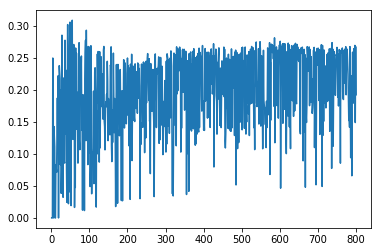

In [243]:
result_mab_eps = []
for number_of_trial in number_of_trials:
    mab_eps = EpsGreedy(10, 0.05)
    result_rewards_per_trial = offlineEvaluate(mab_eps, arms, rewards, contexts, int(number_of_trial))
    result_mab_eps.append(np.mean(result_rewards_per_trial))
fig = plt.figure()
ax = plt.axes()
x = np.linspace(1, 800, 800)
ax.plot(x, result_mab_eps);

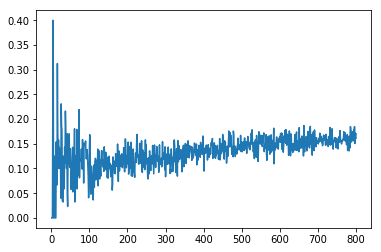

In [241]:
result_mab_ucb = []
for number_of_trial in number_of_trials:
    mab_ucb = UCB(10, 1.0)
    result_rewards_per_trial = offlineEvaluate(mab_ucb, arms, rewards, contexts, int(number_of_trial))
    result_mab_ucb.append(np.mean(result_rewards_per_trial))

fig = plt.figure()
ax = plt.axes()
x = np.linspace(1, 800, 800)
ax.plot(x, result_mab_ucb);

In [ ]:
result_mab_linucb = []
for number_of_trial in tqdm(number_of_trials):
    mab_linucb = LinUCB(10, 10, 1.0)
    result_rewards_per_trial = offlineEvaluate(mab_linucb, arms, rewards, contexts, int(number_of_trial))
    result_mab_linucb.append(np.mean(result_rewards_per_trial))



  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 3/800 [00:00<00:49, 15.94it/s]

  0%|          | 4/800 [00:00<00:59, 13.27it/s]

  1%|          | 6/800 [00:00<01:00, 13.05it/s]

  1%|          | 7/800 [00:00<01:13, 10.82it/s]

  1%|          | 8/800 [00:00<01:26,  9.18it/s]

  1%|          | 9/800 [00:00<01:24,  9.33it/s]

  1%|▏         | 10/800 [00:00<01:27,  9.07it/s]

  1%|▏         | 11/800 [00:01<01:35,  8.29it/s]

  2%|▏         | 12/800 [00:01<01:45,  7.49it/s]

  2%|▏         | 13/800 [00:01<01:46,  7.39it/s]

  2%|▏         | 14/800 [00:01<01:47,  7.30it/s]

  2%|▏         | 15/800 [00:01<01:55,  6.78it/s]

  2%|▏         | 16/800 [00:01<02:08,  6.11it/s]

  2%|▏         | 17/800 [00:02<02:12,  5.92it/s]

  2%|▏         | 18/800 [00:02<02:14,  5.80it/s]

  2%|▏         | 19/800 [00:02<02:41,  4.83it/s]

  2%|▎         | 20/800 [00:02<02:40,  4.87it/s]

  3%|▎         | 21/800 [00:02<02:35,  5.01it/s]

  3%|▎         | 22/800 [00:03<02:39,  4.88it/s]

  3%|▎       

 36%|███▋      | 291/800 [04:23<14:13,  1.68s/it]

 36%|███▋      | 292/800 [04:25<13:56,  1.65s/it]

 37%|███▋      | 293/800 [04:27<13:26,  1.59s/it]

 37%|███▋      | 294/800 [04:28<13:39,  1.62s/it]

 37%|███▋      | 295/800 [04:30<13:48,  1.64s/it]

 37%|███▋      | 296/800 [04:32<13:54,  1.66s/it]

 37%|███▋      | 297/800 [04:33<13:22,  1.60s/it]

 37%|███▋      | 298/800 [04:35<13:58,  1.67s/it]

 37%|███▋      | 299/800 [04:37<14:05,  1.69s/it]

 38%|███▊      | 300/800 [04:38<13:44,  1.65s/it]

 38%|███▊      | 301/800 [04:40<13:20,  1.60s/it]

 38%|███▊      | 302/800 [04:41<13:20,  1.61s/it]

 38%|███▊      | 303/800 [04:43<13:43,  1.66s/it]

 38%|███▊      | 304/800 [04:45<13:43,  1.66s/it]

 38%|███▊      | 305/800 [04:46<13:44,  1.67s/it]

 38%|███▊      | 306/800 [04:48<13:14,  1.61s/it]

 38%|███▊      | 307/800 [04:49<13:10,  1.60s/it]

 38%|███▊      | 308/800 [04:51<13:02,  1.59s/it]

 39%|███▊      | 309/800 [04:53<12:47,  1.56s/it]

 39%|███▉      | 310/800 [04:54

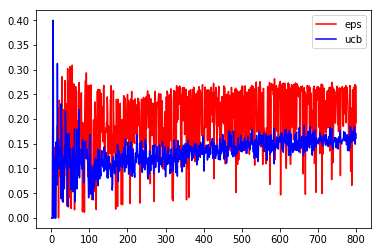

In [244]:
# Answer
fig = plt.figure()
ax = plt.axes()
x = np.linspace(1, 800, 800)
ax.plot(x, result_mab_eps, 'r', label='eps')
ax.plot(x, result_mab_ucb, 'b', label='ucb')
# ax.plot(x, result_mab_linucb, 'g', label='linucb')
ax.legend(loc='upper right')

### 4.B.

1.5887050112577374
2.949474603520405


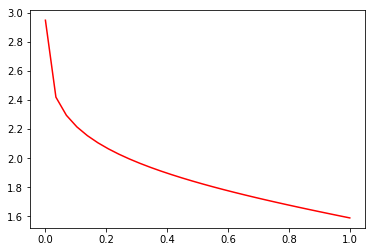

In [152]:
# 0.1, 0.01
# alpha越大，去探索的概率越大。但是说明delta越小，1-delta越大，说明置信度越高。
# alpha最小，alpha最大3
fig = plt.figure()
ax = plt.axes()
delta = np.linspace(0.001, 1, 30)
ax.plot(delta,list(map(lambda delta:(1  + np.sqrt(np.log(2/delta)/2)), delta)), 'r')
print(min(list(map(lambda delta:(1  + np.sqrt(np.log(2/delta)/2)), delta))))
print(max(list(map(lambda delta:(1  + np.sqrt(np.log(2/delta)/2)), delta))))
# A reasonable range of alpha will be 1.6 to 3

In [ ]:
np.linspace(0, 1, 10)

best alpha:2.3777777777777778


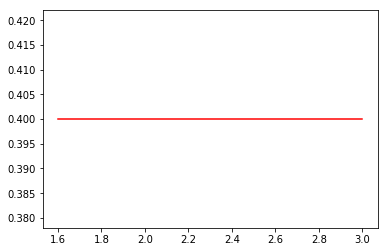

In [158]:
def grid_search(alpha_start, alpha_end):
    result_linucb_alpha = []
    for alpha in np.linspace(alpha_start, alpha_end, 10):
        result_rewards_per_alpha=[]
        mab_linucb = LinUCB(10, 10, alpha)
        result_rewards_per_alpha = offlineEvaluate(mab_linucb, arms, rewards, contexts, 100)
        result_linucb_alpha.append(np.mean(result_rewards_per_alpha))
    best_alpha = np.linspace(alpha_start, alpha_end, 10)[index_max(result_linucb_alpha)]
    return result_linucb_alpha, best_alpha

alpha_start = 1.6
alpha_end = 3
result_linucb_alpha, best_alpha = grid_search(alpha_start, alpha_end)
fig = plt.figure()
ax = plt.axes()
x = np.linspace(alpha_start, alpha_end, 10)
print('best alpha:' + str(best_alpha))
ax.plot(x,result_linucb_alpha, 'r')
# todo 我的alpha的变化不会导致结果的变化

## 5. KernelUCB

In [9]:
# Do not edit. Special import for this section.
from sklearn.metrics.pairwise import rbf_kernel

In [172]:
l = np.array([1,2,5,3])
np.array([1] + [0]*(10-1)).reshape(-1,1)

array([[1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0]])

In [46]:
class KernelUCB(MAB):
    """
    Kernelised contextual multi-armed bandit (Kernelised LinUCB)
    
    Arguments
    =========
    narms : int
        number of arms

    ndims : int
        number of dimensions for each arm's context

    gamma : float
        positive real explore-exploit parameter
    
    eta : float
        positive real explore-exploit parameter
    
    kern : callable
        a kernel function from sklearn.metrics.pairwise
    """
    def __init__(self, narms, ndims, gamma, eta, kern):
        self.narms = narms
        self.ndims = ndims
        self.gamma = gamma
        self.eta = eta
        self.kern = kern
        self.u = np.array([1] + [0]*(self.narms-1)).reshape(-1,1)
        self.y = list()
        self.xt_history = list()
        self.K_t_minus1_inverse = None
        self.tround=None
    
    def play(self, tround, context):
        # 返回argmax(u_t-1)
        self.tround = tround
        return index_max(self.u)
    
    def update(self, arm, reward, context):
        # 继续做u_t的东西
        x_t = context[arm*10:(arm+1)*10]
        # length为t-1
        self.y.append(reward)
        # length为t了
        self.xt_history.append(x_t)
        y_t = np.array(self.y).reshape(-1,1)
        # t * 1 dimensional
        # 需要x_t, xt_history, tround
        # 注意xt_history得是tround * 1 的
        k_xt_t = np.array(list(map(lambda x,y:kern(x,y),[x_t]*self.tround, self.xt_history))).reshape(-1,1)
        
        if self.tround == 1:
            K_t_inverse = 1/(self.kern(x_t, x_t) + self.eta)
            self.K_t_minus1_inverse = K_t_inverse
        else:
            # (tround - 1) * 1的
            b = np.array(list(map(lambda x,y:kern(x,y),[x_t]*self.tround, self.xt_history[:-1]))).reshape(-1,1)
            K_22 = 1/(self.kern(x_t, x_t) + self.eta - np.linalg.multi_dot([b.T, self.K_t_minus1_inverse, b]))
            K_11 = self.K_t_minus1_inverse + np.linalg.multi_dot([K_22, self.K_t_minus1_inverse, b, b.T, self.K_t_minus1_inverse])
            K_12 = np.linalg.multi_dot([-K_22, self.K_t_minus1_inverse, b])
            K_21 = np.linalg.multi_dot([-K_22, b.T, self.K_t_minus1_inverse])
            K_t_inverse = np.block([[K_11, K_12],[K_21, K_22]])
        sigma_t = []
        u_t = []
        for arm in range(self.narms):
            x_nt = context[arm*10:(arm+1)*10].reshape(-1,1)
            k_xntt = np.array(list(map(lambda x,y:kern(x,y), [x_nt]*self.tround, self.xt_history))).reshape(-1,1)
            print(x_nt*self.tround)
            print([x_nt]*self.tround)
            print(self.xt_history)
            
            print(x_nt.shape)
            print(k_xntt.shape)
            print(K_t_inverse.shape)
            sigma_nt = np.sqrt(self.kern(x_nt, x_nt) - np.linalg.multi_dot([k_xntt.T, K_t_inverse, k_xntt]))
            sigma_t.append(sigma_nt)
            u_nt = np.linalg.multi_dot([k_xntt.T, K_t_inverse, y_t]) + self.eta/sqrt(self.gamma) * sigma_nt
            u_t.append(u_nt)
        # 更新u_t
        self.u = u_t
        # 下一轮的
        self.K_t_minus1_inverse = K_t_inverse

In [52]:
array1 = np.array([[22],
       [ 0],
       [ 0],
       [38],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0]])
array2 = np.array([22,  0,  0, 38,  0,  0,  0,  0,  0,  0])
kern(array1, array2)

array([[1.]])

In [50]:
?rbf_kernel

In [51]:
def kern(X, Y):
    """
    RBF_kernel with gamma preset
    """
    gamma = 0.1
    X = X.reshape(1,-1)
    Y = Y.reshape(1,-1)
    return rbf_kernel(X, Y, gamma)

mab_kern = KernelUCB(10, 10, 0.05, 0.1, kern)
results_kern = offlineEvaluate(mab_kern, arms, rewards, contexts, 800)
print(results_kern)
print('kernel average reward', np.mean(results_kern))

ValueError: Incompatible dimension for X and Y matrices: X.shape[1] == 1 while Y.shape[1] == 10